In [1]:
import pandas as pd
import numpy as np
import re
import string
import time
from datetime import datetime
from datetime import date
import os
import random

#Plotting
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# ML Libraries

from sklearn.ensemble import BaggingClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.multiclass import OneVsRestClassifier


from sklearn import svm
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn import metrics

# Save model
import pickle
import joblib

## Run settings

chosen_feature_predicting : Gender, rating_count , rating_value , review_count_critic , review_count_user , metascore
<br>chosen_bin_method : quartiles , bin_cut , Bin_AsPaper
<br>chosen_success_class : movie_rating , director_rating
<br>chosen_dataset_balance : unbalanced , balanced
<br>chosen_kernel_type : linear , poly , rbf, LinearSVC

In [2]:
# chosen_feature_predicting = 'Gender'
gender_as_an_input = 'Yes'
chosen_feature_predicting = 'rating_count'
chosen_bin_method = 'quartiles'
chosen_success_class = 'movie_class'
chosen_dataset_ratio = 'unbalanced'
chosen_kernel_type = 'LinearSVC'
chosen_gamma_type = 'auto'
chosen_scaling_method = 'MinMaxScaler'

In [3]:
# directorDFfileLocation = 'C:\\Yuva\\ITU\\4th Sem\\Thesis\\Data\\cumulativeDirectorDF_Mar-21-2020.csv'
# moviesDataFileLocation = 'C:\\Yuva\\ITU\\4th Sem\\Thesis\\Data\\OnlyMovieDirectorDF.csv'

# moviesDataFileLocation = 'C:\\Yuva\\ITU\\4th Sem\\Thesis\\Data\\1_Data_Movies.csv'
# moviesDataFileLocation = 'C:\\Yuva\\ITU\\4th Sem\\Thesis\\Data\\2_Movies_WithAwards.csv'
# moviesDataFileLocation = 'C:\\Yuva\\ITU\\4th Sem\\Thesis\\Data\\3_USA_Movies_WithAwards.csv'


# dynamic path location

# moviesDataFileLocation = os.path.join(os.path.realpath(os.path.pardir),'datasets\\data1_Data_Movies.csv')
# moviesDataFileLocation = os.path.join(os.path.realpath(os.path.pardir),'datasets\\data2_Movies_WithAwards.csv')
moviesDataFileLocation = os.path.join(os.path.realpath(os.path.pardir),'datasets\\data3_USA_Movies_WithAwards.csv')

# storedDF = 'C:\\Yuva\\ITU\\4th Sem\\Thesis\\Data\\StoreDF_Mar-25-2020.csv'
# storeModelLocation = 'C:\\Yuva\\ITU\\4th Sem\\Thesis\\Data\\Classification Models\\SVM'

saveFileToPath = "C:\\Yuva\\ITU\\4th Sem\\Thesis\\Data\\"

movies_data = pd.read_csv(moviesDataFileLocation)
movies_data.info()
# storeDF = pd.read_csv(storedDF)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2653 entries, 0 to 2652
Columns: 108 entries, director_ids to awards_won
dtypes: float64(29), int64(69), object(10)
memory usage: 2.2+ MB


In [4]:
# storeDF_col_names =  ['run_model','features_selected', 'record_count', 'male_count','female_count','predicting','Order_ABS','Order_Pos_Neg',
#               'TN','FP','FN','TP','total_time']
# # storeDF  = pd.DataFrame(columns = storeDF_col_names)

In [5]:
def undersampling_balanced_gender(df,balance_feature = 'Gender', column_tobe_unique = 'director_ids'):
    
    # Shuffle the Dataset.
    shuffled_data = df.sample(frac=1,random_state=42)
    print('Unbalanced dataframe shape after undersampling :',shuffled_data.shape)

    # First remove all duplicates director_ids to have only unique columns
    unique_column_df = shuffled_data.drop_duplicates(subset = column_tobe_unique, keep='first', inplace=False)
    unique_column_df.shape
    
    # An empty balanced data frame with only the unique columns
    bal_total_unique_list_df = pd.DataFrame()
    
    # Add balanced values from all the possible classes    
    for i in unique_column_df[balance_feature].value_counts().index:
        bal_total_unique_list_df = bal_total_unique_list_df.append(unique_column_df[(unique_column_df[balance_feature]==i)]
                                                   .sample(
                                                       n= unique_column_df[balance_feature].value_counts().values.min(),
                                                       random_state = 42,
                                                       replace = False)
                                                  )
    # list of unique IDs
    total_list_unique_IDs = bal_total_unique_list_df[column_tobe_unique].to_list()
    
    balanced_data = shuffled_data[shuffled_data[column_tobe_unique].isin(total_list_unique_IDs)] 
    
    print('Balanced dataframe shape after undersampling :',balanced_data.shape)
    return balanced_data

# Functions : Bin Cuts , Quartile Bins and bins as in paper

## Bin Cuts

In [6]:
def bincuts(df,class_feature = 'rating_value'):
    
    # Bin cuts into 4 buckets

    bin_quartiles = ['terrible','poor','average','excellent']
    cutIntoQuartiles = pd.cut(df[class_feature].to_list(), bins = 4 ,labels=bin_quartiles)

    # Print the quartile range for visuals
    print(cutIntoQuartiles.categories)

    # Add the data to the dataframe
    df[chosen_success_class] = cutIntoQuartiles
    print('The shape of our Movies dataset is:', df.shape)
    df.drop(columns = [class_feature] , inplace = True)
    print('The shape of our Movies dataset is:', df.shape)

## Quartile Bins

In [7]:
def quartile_bin(df,class_feature='rating_value'):
    # Quartile cut into 4 different buckets

    bin_quartiles = ['terrible','poor','average','excellent']
    cutIntoQuartiles = pd.qcut(df[class_feature].to_list(), q=4,labels=bin_quartiles)
    
    print(cutIntoQuartiles.categories)
    
    df[chosen_success_class] = cutIntoQuartiles
    df[chosen_success_class] = df[chosen_success_class].astype(object)
    print('The shape of our dataset before dropping the class feature is:', df.shape)
    df.drop(columns = [class_feature] , inplace = True)
    print('The shape of our dataset after dropping the class feature  is:', df.shape)
    return df

## Paper Implementation of bins

In [8]:
def success_measure(score):
    
    if score > 0 and score <= 2.4:
        return 'poor'
#     elif score > 2.4 and score <= 5.0:a
        return 'average'
    elif score > 5.0 and score <= 7.4:
        return 'good'
    elif score > 7.4 and score <=10.0:
        return 'excellent'
    else:
        return 'Error_Score'

# Function - To choose which Success measure to choose and what binning technique

In [9]:
def choose_success_measure(df, bin_method = 'Quartiles', feature = 'rating_value'):
    
    # Stats of the feature
    print('\nDescribing the feature : \n')
    print(df[feature].describe())
    

    
    if (bin_method == 'quartiles'):
        # Quartie bin cuts
        df = quartile_bin(df,feature)
            
    elif(bin_method == 'bin_cut'):
        # Bin cuts
        df = bincuts(df,'rating_value')
        
    elif(bin_method == 'Bin_AsPaper'):
        df[chosen_success_class] = df[feature].apply(success_measure).astype('category')
        
    print('\nThe shape of our dataset is:', df.shape)
    
    print('\nValue Count of the bucketed class is : \n')
    print(df[chosen_success_class].value_counts())

### Balance Gender

In [10]:
balanced_movies_data = undersampling_balanced_gender(movies_data)

Unbalanced dataframe shape after undersampling : (2653, 108)
Balanced dataframe shape after undersampling : (700, 108)


In [11]:
balanced_movies_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 700 entries, 1229 to 1238
Columns: 108 entries, director_ids to awards_won
dtypes: float64(29), int64(69), object(10)
memory usage: 596.1+ KB


### Choosing dataset for the analysis

In [12]:
chosen_dataframe = ''
if(chosen_dataset_ratio == 'unbalanced'):
    chosen_dataframe = movies_data
elif(chosen_dataset_ratio == 'balanced'):
    chosen_dataframe = balanced_movies_data

### Remove Features from dataset which are not required

In [13]:
object_features_to_remove = chosen_dataframe.select_dtypes(include = 'object').columns.values.tolist()
object_features_to_remove.remove('Gender')
object_features_to_remove

['director_ids',
 'director_names',
 'movie_id',
 'title',
 'release_date',
 'clean_director_names',
 'FirstName',
 'Film',
 'Name']

## Run the feature based on the bin cut and success feature

In [14]:
chosen_feature_predicting

'rating_count'

In [15]:
cutIntoQuartiles = pd.qcut(chosen_dataframe[chosen_feature_predicting].to_list(), q=4)
print("Quantiles bin range")
for i,num in enumerate(cutIntoQuartiles.categories):
    print("Quantile {0} : {1} ".format(i,num))

Quantiles bin range
Quantile 0 : (28.999, 18453.0] 
Quantile 1 : (18453.0, 53746.0] 
Quantile 2 : (53746.0, 131546.0] 
Quantile 3 : (131546.0, 1718048.0] 


In [16]:
choose_success_measure(chosen_dataframe , bin_method = chosen_bin_method , feature = chosen_feature_predicting)


Describing the feature : 

count    2.653000e+03
mean     1.058002e+05
std      1.479954e+05
min      2.900000e+01
25%      1.845300e+04
50%      5.374600e+04
75%      1.315460e+05
max      1.718048e+06
Name: rating_count, dtype: float64
Index(['terrible', 'poor', 'average', 'excellent'], dtype='object')
The shape of our dataset before dropping the class feature is: (2653, 109)
The shape of our dataset after dropping the class feature  is: (2653, 108)

The shape of our dataset is: (2653, 108)

Value Count of the bucketed class is : 

terrible     664
poor         663
excellent    663
average      663
Name: movie_class, dtype: int64


In [17]:
# movies_data[chosen_success_class] = movies_data[chosen_success_class].map({'terrible':1,'poor':2,'average':3,'excellent':4})

In [18]:
movies_data.shape

(2653, 108)

### Chosen Movies Dataset

In [19]:
print('The shape of our chosen Movies dataset before removing object type features:', chosen_dataframe.shape)
# movies_data = movies_data[movies_data.columns.difference(object_features_to_remove)]
chosen_dataframe = chosen_dataframe.drop(columns= object_features_to_remove)
print('The shape of our chosen Movies dataset after dropping object type features:', chosen_dataframe.shape)

The shape of our chosen Movies dataset before removing object type features: (2653, 108)
The shape of our chosen Movies dataset after dropping object type features: (2653, 99)


In [20]:
chosen_dataframe[chosen_success_class].value_counts()

terrible     664
poor         663
excellent    663
average      663
Name: movie_class, dtype: int64

### Generic Functions

In [21]:
# Helper method for save_to_file

def get_df_name(df):
    name =[x for x in globals() if globals()[x] is df][0]
    return name

In [22]:
# Function: Save Dataframe to CSV

def save_to_file(dataFrame, folderPath):
    today = date.today()
    todayDate = today.strftime("%b-%d-%Y")
#     dataFrame.to_csv(folderPath+ '\\' + get_df_name(dataFrame) + '_' + todayDate  + '.csv',index=False, encoding="utf8" )
    dataFrame.to_csv(folderPath+ '\\' + get_df_name(dataFrame) + '_' + todayDate  + '.csv',index=False, encoding="utf-8-sig" )

### One hot encoding for Gender

In [23]:
def one_hot_encode_gender(df,one_hot_feature = 'Gender'):
    print('Before one hot encoding , Shape ;', df.shape)
    # one hot encoding of Gender
    df = pd.concat([df, pd.get_dummies(df[one_hot_feature],prefix= one_hot_feature,dtype = int)],axis=1)
    df.drop([one_hot_feature],axis=1, inplace=True)
    print('After one hot encoding , Shape ;', df.shape)
    df.head(2)
    return df

In [24]:
chosen_dataframe = one_hot_encode_gender(chosen_dataframe)

Before one hot encoding , Shape ; (2653, 99)
After one hot encoding , Shape ; (2653, 100)


In [25]:
def reverse_one_hot_encoding(df):
    reverse_one_hot_Gender = df.loc[:, df.columns.str.startswith('Gender')].idxmax(axis = 'columns')
    df['Gender'] = reverse_one_hot_Gender

    # Replace Gender_Male with Male and Gender_Female with Female
    df['Gender'] = df['Gender'].str.replace('Gender_male','Male')
    df['Gender'] = df['Gender'].str.replace('Gender_Female','Female')
    # Drop the one hot encoded value
    df.drop(['Gender_Female','Gender_male'],axis=1, inplace=True)
    return df

## Decide if Gender is an input feature or not

In [26]:
gender_as_an_input

'Yes'

In [27]:
if(gender_as_an_input == 'Yes'):
    print("Gender is an input feature for this run! No dropping!")
    print('The shape of our Chosen dataset after dropping Gender features:', chosen_dataframe.shape)
else:
    chosen_dataframe.drop(columns = ['Gender_Male','Gender_Female'],inplace = True)
    print("Gender features removed as it is not an input feature for this run!  ")
    print('The shape of our Chosen dataset after dropping Gender features:', chosen_dataframe.shape)

Gender is an input feature for this run! No dropping!
The shape of our Chosen dataset after dropping Gender features: (2653, 100)


In [28]:
chosen_dataset_ratio

'unbalanced'

In [29]:
chosen_dataframe[chosen_success_class].value_counts()

terrible     664
poor         663
excellent    663
average      663
Name: movie_class, dtype: int64

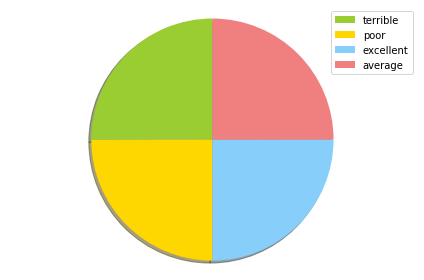

In [30]:
# Visualizing Outcome Distribution 
temp = chosen_dataframe[chosen_success_class].value_counts()
df = pd.DataFrame({'labels': temp.index,
                   'values': temp.values
                  })

#df.plot(kind='pie',labels='labels',values='values', title='Activity Ditribution',subplots= "True")

labels = df['labels']
sizes = df['values']
colors = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral','cyan']
patches, texts = plt.pie(sizes, colors=colors, shadow=True, startangle=90, pctdistance=1.1, labeldistance=1.2)
plt.legend(patches, labels, loc="best")
plt.axis('equal')
plt.tight_layout()
plt.show()

In [31]:
def divide_test_train_with_scaling_methods(df,predict= chosen_success_class,scalingMethod = "MinMaxScaler"):
    
    
    # Feature matrix and target variable
    X = df.drop(predict,axis = 'columns')
    y = df[predict]
    
    # Scaling
    if (scalingMethod == "MinMaxScaler"):
        print("The scaling method used is : ",scalingMethod)
        scaler = MinMaxScaler()
        new_X = scaler.fit_transform(X)
        # X_test = scaler.transform(X_test)
        
    else:
        print("No Scaling Method used or incorrect input")
        new_X = X
    
    # Divide the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(new_X, y, test_size=0.20, random_state = 42 , stratify = y )
    
    return X_train, X_test, y_train, y_test

# Plot Confusion Matrix

In [32]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

### Function for Run Info :

In [33]:
def run_info(classifier):
    print('\n**Run Info - ' + classifier + '**')
    print('Dataset Shape :', chosen_dataframe.shape)
    print('Dataset ratio of classes is', chosen_dataset_ratio)
    print('Is gender an input feature :  ', gender_as_an_input)
    print('Predicting feature :', chosen_feature_predicting)
    print('Bin Method :', chosen_bin_method)
    print('Scaling Method :', chosen_scaling_method)
    print('With Gender?? :', gender_as_an_input)
    print('****************\n')
    return

### Function to print customized classification report

In [34]:
def customized_classification_report(y_true,y_pred, AUCROC ):
    cols_to_use_classification_report = ['terrible','poor','average','excellent','accuracy']
    reportGBClassification = classification_report(y_true,
                                                   y_pred,
                                                   labels = cols_to_use_classification_report[:-1],
                                                   output_dict=True)
    
    reportDF = pd.DataFrame(reportGBClassification, columns = cols_to_use_classification_report)[0:3]
    reportDF[['terrible','poor','average','excellent']] = reportDF[['terrible','poor','average','excellent']].round(2)
    
    accuracyRow = reportDF['accuracy'].unique().tolist()
    
    reportDF.drop(columns='accuracy',inplace= True)

    reportDF.loc[len(reportDF)] = 4 * accuracyRow
    reportDF.loc[len(reportDF)] = 4 * [round(AUCROC,2)]

    reportDF = reportDF.rename(index = {3:'accuracy',4:'AUC ROC'})
    return reportDF

# SVM Classifier

In [35]:
def train_model_SVM_classifier(X_train, X_test, y_train, y_test,kernelType='linear',gamma_parameter='auto'):
    
    start = time.time()
    print("Started Reading files at :" + str(datetime.utcfromtimestamp(start).strftime('%Y-%m-%d %H:%M:%S')))
    
    labelMovieClass = ['terrible','poor','average','excellent']
#     labelMovieClass = [1,2,3,4]
    
    # SVM Classifier parameters
    
    if(kernelType == 'linear'):
        svclassifier = SVC(kernel = kernelType,
                           gamma = gamma_parameter,
                           probability=True
                          )
        
    elif(kernelType == 'LinearSVC'):
        svclassifier = LinearSVC(random_state = 42,
                                 tol=1e-5,
                                 multi_class = 'ovr'
                                )
        # Using Calibrated Classifier cross validation and One VsRest classifier
        clf0 = CalibratedClassifierCV(svclassifier, cv=10)
        clf = OneVsRestClassifier(clf0, n_jobs = 10)
        
    elif(kernelType == 'poly'):
        svclassifier = SVC(kernel=kernelType,
                           gamma = gamma_parameter,
#                            probability=True,
                           degree=8
                          )
    elif(kernelType == 'rbf'):
        svclassifier = SVC(kernel=kernelType,
#                            probability=True,
                    )
    elif(kernelType == 'sigmoid'):
        svclassifier = SVC(kernel=kernelType,
#                            probability=True,
                )
    
#     #Using Bagging classifier with SVC
#     clf = BaggingClassifier(base_estimator = svclassifier,
#                                      n_estimators=10, 
#                                      random_state= 42)    
    
#     #Using One Vs Rest classifier with SVC    
#     clf = OneVsRestClassifier(svclassifier, n_jobs = 10)
    
     



    
    # SVM Classifier Fit
    clf.fit(X_train, y_train)

    # Predict classes
    y_pred = clf.predict(X_test)
    y_prob = clf.predict_proba(X_test)

    
#     cnf_matrix = confusion_matrix(y_test, y_pred,labels= labelMovieClass )
    cnf_matrix = confusion_matrix(y_test, y_pred)
#     np.set_printoptions(precision=2)
    
    classifier_name = svclassifier.__class__.__name__
    train_size = int(round((len(X_train) / len(chosen_dataframe)),1) * 100)
    test_size = int(round((len(X_test) / len(chosen_dataframe)),1) * 100)
    
    # Print run info
    run_info(classifier_name)
    
    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes= labelMovieClass,
                      title='Confusion matrix, without normalization')
    
       
    svm_train_score = clf.score(X_train, y_train)
    print("\nTraining Score of {0} on {2} % data : {1} ".format(classifier_name,round(svm_train_score,3),train_size))
    
    svm_test_score = clf.score(X_test, y_test)
    print("Testing Score of {0} on {2} % data : {1} ".format(classifier_name,round(svm_test_score,3),test_size))

    # Performance metrics
    macro_ovo_roc_auc = roc_auc_score(y_test, y_prob,average= "macro" , multi_class = 'ovo')
    print( "\nArea Under the Curve - ROC (OVO , Macro) : ",round(macro_ovo_roc_auc,3))
    print( "Matthews_corrcoef : ", round(metrics.matthews_corrcoef(y_test, y_pred),3))
    

    print("\nClassification Report\n")
    print(classification_report(y_test, y_pred, labels = labelMovieClass ))
    
    # Stop timer
    end = time.time()
    print("\nStopped Reading files at :" + str(datetime.utcfromtimestamp(end).strftime('%Y-%m-%d %H:%M:%S')))
    total_time = str(round((end - start)/60,2))
    print("Total time taken in seconds: " + str((end - start)))
    
    return svclassifier,y_test,y_pred,macro_ovo_roc_auc

## Running Director Dataset - with model features

### Small sample for test

In [36]:
# for i in range(2):
#     print('Round',i+4)
#     NOR= 10000 * (i+4)
#     print('Number of Rows',NOR)
#     testSample =  chosen_dataframe.sample(n= NOR , random_state = 42 , replace = False)
#     # Divide the data into training and test
#     X_train, X_test, y_train, y_test = divide_test_train_with_scaling_methods(testSample,scalingMethod= chosen_scaling_method)
#     svclassifier,total_time = train_model_SVM_classifier(X_train, X_test, y_train, y_test,kernelType= chosen_kernel_type ,gamma_parameter= chosen_gamma_type)
#     print('Total Time in minutes: ', total_time )

In [37]:
# # Comment this line if you want to use the originally chosen dataframe

# testSample =  chosen_dataframe.sample(n= 10000 , random_state = 42 , replace = False)
# # chosen_dataframe = testSample

In [38]:
chosen_dataframe[chosen_dataframe['birthYear'] == 6]

,review_count_user,review_count_critic,metascore,rating_value,runtime,movie_year,opening_weekend_value,gross_value,budget_value,color_Black_and_White,...,Winner_Actress in a Supporting Role,Winner_Assistant Director,Winner_Directing,Winner_Directing (Comedy Picture),Winner_Directing (Dramatic Picture),awards_nominated,awards_won,movie_class,Gender_Female,Gender_Male


In [39]:
# Divide the data into training and test

X_train, X_test, y_train, y_test = divide_test_train_with_scaling_methods(chosen_dataframe,scalingMethod= chosen_scaling_method)

The scaling method used is :  MinMaxScaler


In [40]:
X_train.shape , y_train.shape

((2122, 99), (2122,))

In [41]:
X_test.shape , y_test.shape

((531, 99), (531,))

For Dataset 1<br>
50 seconds for 10000 records<br>
200 seconds for 20000 records

Started Reading files at :2020-05-22 16:08:34

**Run Info - LinearSVC**
Dataset Shape : (2653, 100)
Dataset ratio of classes is unbalanced
Is gender an input feature :   Yes
Predicting feature : rating_count
Bin Method : quartiles
Scaling Method : MinMaxScaler
With Gender?? : Yes
****************

Confusion matrix, without normalization
[[ 56  29  44   3]
 [ 10 119   4   0]
 [ 25   1  73  34]
 [  1   0  17 115]]

Training Score of LinearSVC on 80 % data : 0.727 
Testing Score of LinearSVC on 20 % data : 0.684 

Area Under the Curve - ROC (OVO , Macro) :  0.894
Matthews_corrcoef :  0.581

Classification Report

              precision    recall  f1-score   support

    terrible       0.76      0.86      0.81       133
        poor       0.53      0.55      0.54       133
     average       0.61      0.42      0.50       132
   excellent       0.80      0.89      0.84       133

    accuracy                           0.68       531
   macro avg       0.67      0.68      0.67       531
we

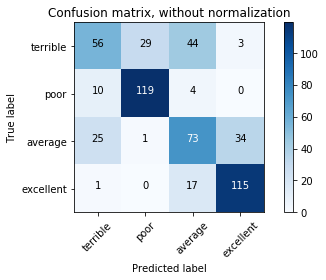

In [42]:
svclassifier,y_true , y_pred, AUCROC  = train_model_SVM_classifier(X_train, X_test, y_train, y_test,kernelType= chosen_kernel_type ,gamma_parameter= chosen_gamma_type)

In [43]:
SVM_reportDF = customized_classification_report(y_true,y_pred,AUCROC)
SVM_reportDF

,terrible,poor,average,excellent
precision,0.760000,0.530000,0.610000,0.800000
recall,0.860000,0.550000,0.420000,0.890000
f1-score,0.810000,0.540000,0.500000,0.840000
accuracy,0.683616,0.683616,0.683616,0.683616
AUC ROC,0.890000,0.890000,0.890000,0.890000


In [44]:
break

SyntaxError: 'break' outside loop (<ipython-input-44-6aaf1f276005>, line 4)

# Code ends here for SVM Testing

In [ ]:
# temp_director_only = movies_data.dropna(subset=model_features)
temp_director_only = movies_data
temp_director_only.info()

In [ ]:
def print_features_selected(df):
    print('[',end = '')
    for i,v in enumerate(df.columns.values):
        if(i==len(df.columns.values)-1):
            print("'" + str(v) +"']")
        else:
            print("'" + str(v) +"',")

In [ ]:
# # print_features_selected(temp_director_only)
# print_features_selected(maxEqualDF[model_features])

## Running Whole Director DF 

In [ ]:
y_test,y_pred,model_SVC = run_model_SVM(df = temp_director_only,
                                        predictingFeature= chosen_feature_predicting,
                                        kernelType= chosen_kernel_type,
                                        gamma= chosen_gamma_type
                                       )


In [ ]:
# y_test,y_pred,model_SVC,storeDF.loc[len(storeDF)] = run_model_SVM(model_comments,temp_director_only,storeDF,
#                                                                   model_features,'Gender','linear','auto')

In [ ]:
evaluation_analysis(y_test,y_pred)

In [ ]:
storeDF

In [ ]:
# #Save a copy of true and predicted for Manual intervention
# Actual = y_test.to_frame()
# Actual['predicter'] = y_pred
# save_to_file(Actual,saveFileToPath)

## Running Balanced max Equal DF 

In [ ]:
y_test,y_pred,model_SVC,storeDF.loc[len(storeDF)] = run_model_SVM(model_comments,maxEqualDF,storeDF,
                                                                  model_features,'Gender','linear','auto')

In [ ]:
evaluation_analysis(y_test,y_pred)

In [ ]:
storeDF

## Test Run sample DF

In [ ]:
y_test,y_pred,model_SVC,storeDF.loc[len(storeDF)] = run_model_SVM(model_comments,equalDF,storeDF,
                                                                  model_features,'Gender','poly','auto')

In [ ]:
evaluation_analysis(y_test,y_pred)

In [ ]:
evaluation_analysis(y_test,y_pred)

In [ ]:
storeDF

In [ ]:
save_to_file(storeDF,saveFileToPath)